# MyoSuite (Figures 17/18)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rliable import library as rly
from rliable import metrics, plot_utils
import utils

In [2]:
main_envs = [
    "myo-hand-reach", 
    "myo-hand-key-turn", 
    "myo-hand-obj-hold", 
    "myo-hand-pose", 
    "myo-hand-pen-twirl"
]
main_envs.sort()

In [3]:
df = pd.concat([
    pd.read_csv("../data/myo-dcmpc.csv"),
    pd.read_csv("../data/baselines/sac.csv"),
    pd.read_csv("../data/baselines/tdmpc2.csv"),
    pd.read_csv("../data/baselines/tdmpc.csv"),
    pd.read_csv("../data/baselines/dreamerv3.csv"),
])

/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_73387/2193240365.py:55: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


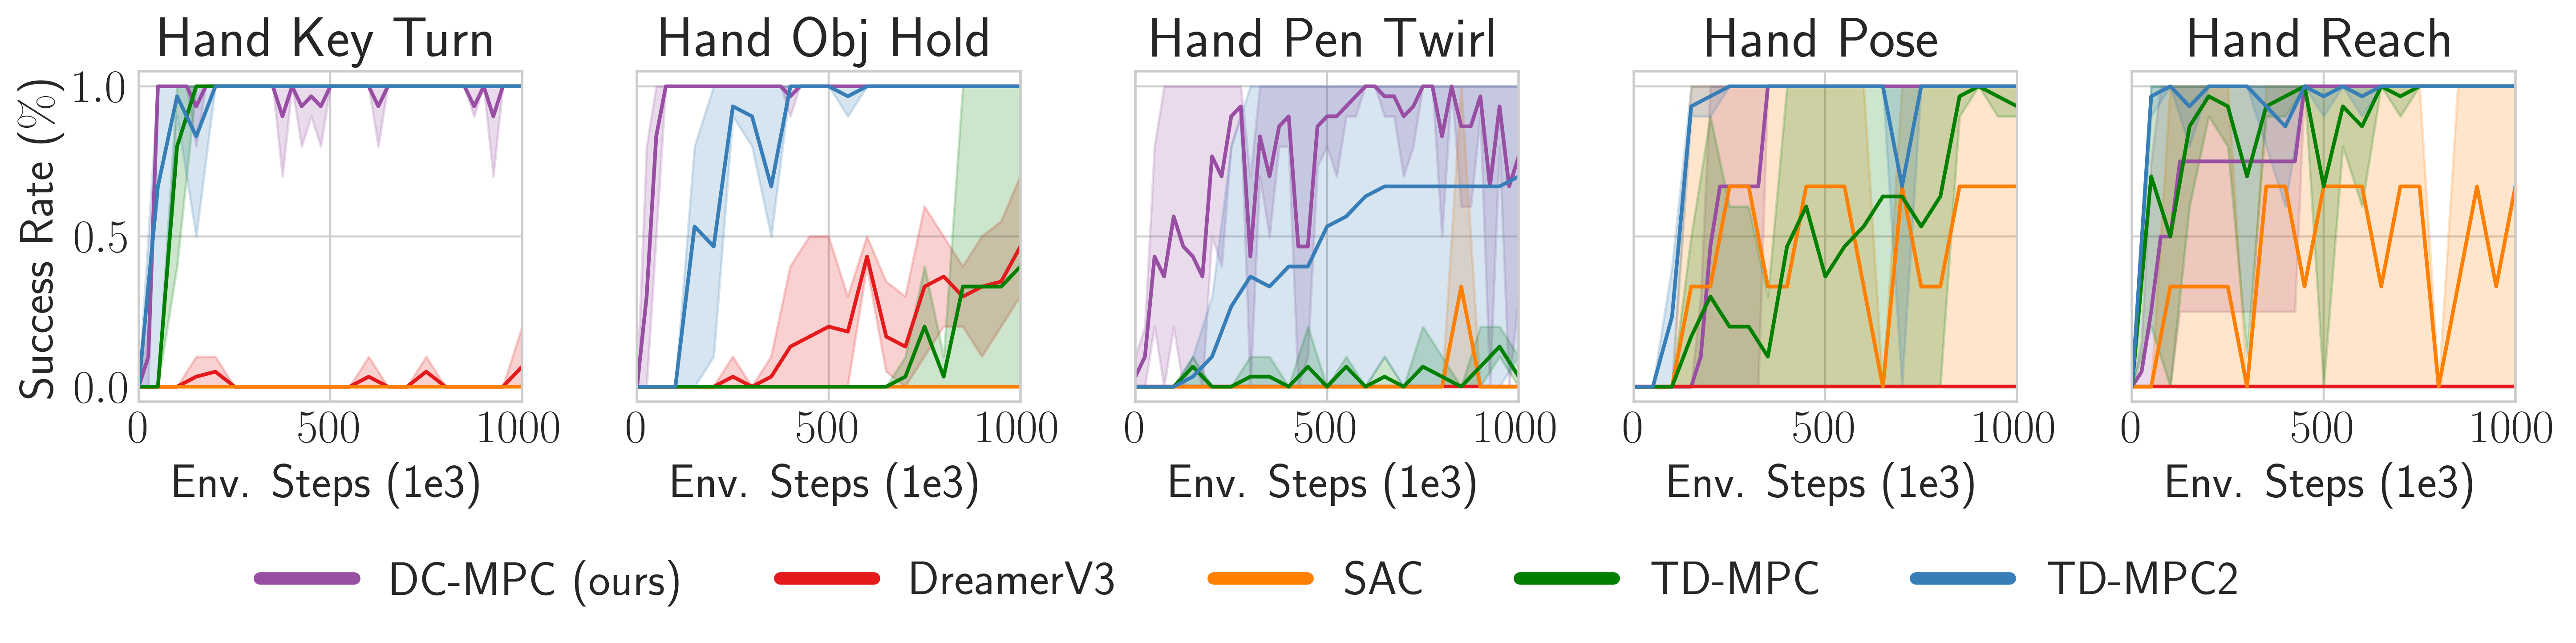

In [4]:
def plot(df, key="episode_success"):
    plt.rcParams["font.size"] = 19
    plt.rcParams["legend.fontsize"] = 19

    # Only keep MyoSuite envs
    df = df[df["env"].isin(main_envs)]

    df.loc[:, "agent"] = df["agent"].replace(utils.AGENTS)

    ncol = 5
    nrow = 1
    fig, axs = plt.subplots(
        nrow,
        ncol,
        figsize=(3 * ncol, 3.5 * nrow),
        sharex="col",
        sharey="row",
    )

    df.loc[:, "env_step"] = (df["env_step"] // 1000).astype(int)

    for idx, env in enumerate(main_envs):
        data = df[df["env"] == env]
        col = idx % ncol
        ax = axs[col]
        legend = idx == len(main_envs) - 1

        g = sns.lineplot(
            x="env_step",
            y=key,
            data=data,
            errorbar=("ci", 95),
            hue="agent",
            hue_order=np.sort(data.agent.unique()),
            palette=utils.PALETTE,
            legend="auto" if legend else False,
            ax=ax,
        )

        ax.set_title(" ".join([ele.capitalize() for ele in env.split("-")[1:]]))
        ax.set_xlabel("Env. Steps (1e3)")
        g.set(xlim=(0, 1000))

    axs[0].set_ylabel(utils.YLABELS[key])

    l = axs[-1].legend(
        loc="upper center",
        bbox_to_anchor=(-2.3, -0.35),
        fancybox=False,
        shadow=False,
        ncol=len(df.agent.unique()),
    )
    for line in l.get_lines():
        line.set_linewidth(5.0)
    plt.tight_layout()
    fig.subplots_adjust(
        bottom=0.35,
        hspace=0.3,
        wspace=0.3,
        left=0.08,
        right=0.97,
        top=0.88,
    )
    plt.savefig(f"./figs/myosuite.pdf")

plot(df)

[1 2 3] for DC-MPC (ours) in myo-hand-reach, env_step=[1000000.]
[1 2 3] for DC-MPC (ours) in myo-hand-pose, env_step=[1000000.]
[1 2 3] for DC-MPC (ours) in myo-hand-pen-twirl, env_step=[1000000.]
[1 2 3] for DC-MPC (ours) in myo-hand-obj-hold, env_step=[1000000.]
[1 2 3] for DC-MPC (ours) in myo-hand-key-turn, env_step=[1000000.]
[1 2 3] for TD-MPC2 in myo-hand-reach, env_step=[1000000.]
[1 2 3] for TD-MPC2 in myo-hand-pose, env_step=[1000000.]
[1 2 3] for TD-MPC2 in myo-hand-pen-twirl, env_step=[1000000.]
[1 2 3] for TD-MPC2 in myo-hand-obj-hold, env_step=[1000000.]
[1 2 3] for TD-MPC2 in myo-hand-key-turn, env_step=[1000000.]
[1 2 3] for DreamerV3 in myo-hand-reach, env_step=[1000000.]
[1 2 3] for DreamerV3 in myo-hand-pose, env_step=[1000000.]
[1 2 3] for DreamerV3 in myo-hand-pen-twirl, env_step=[1000000.]
[1 2 3] for DreamerV3 in myo-hand-obj-hold, env_step=[1000000.]
[1 2 3] for DreamerV3 in myo-hand-key-turn, env_step=[1000000.]
[1 2 3] for SAC in myo-hand-reach, env_step=[100

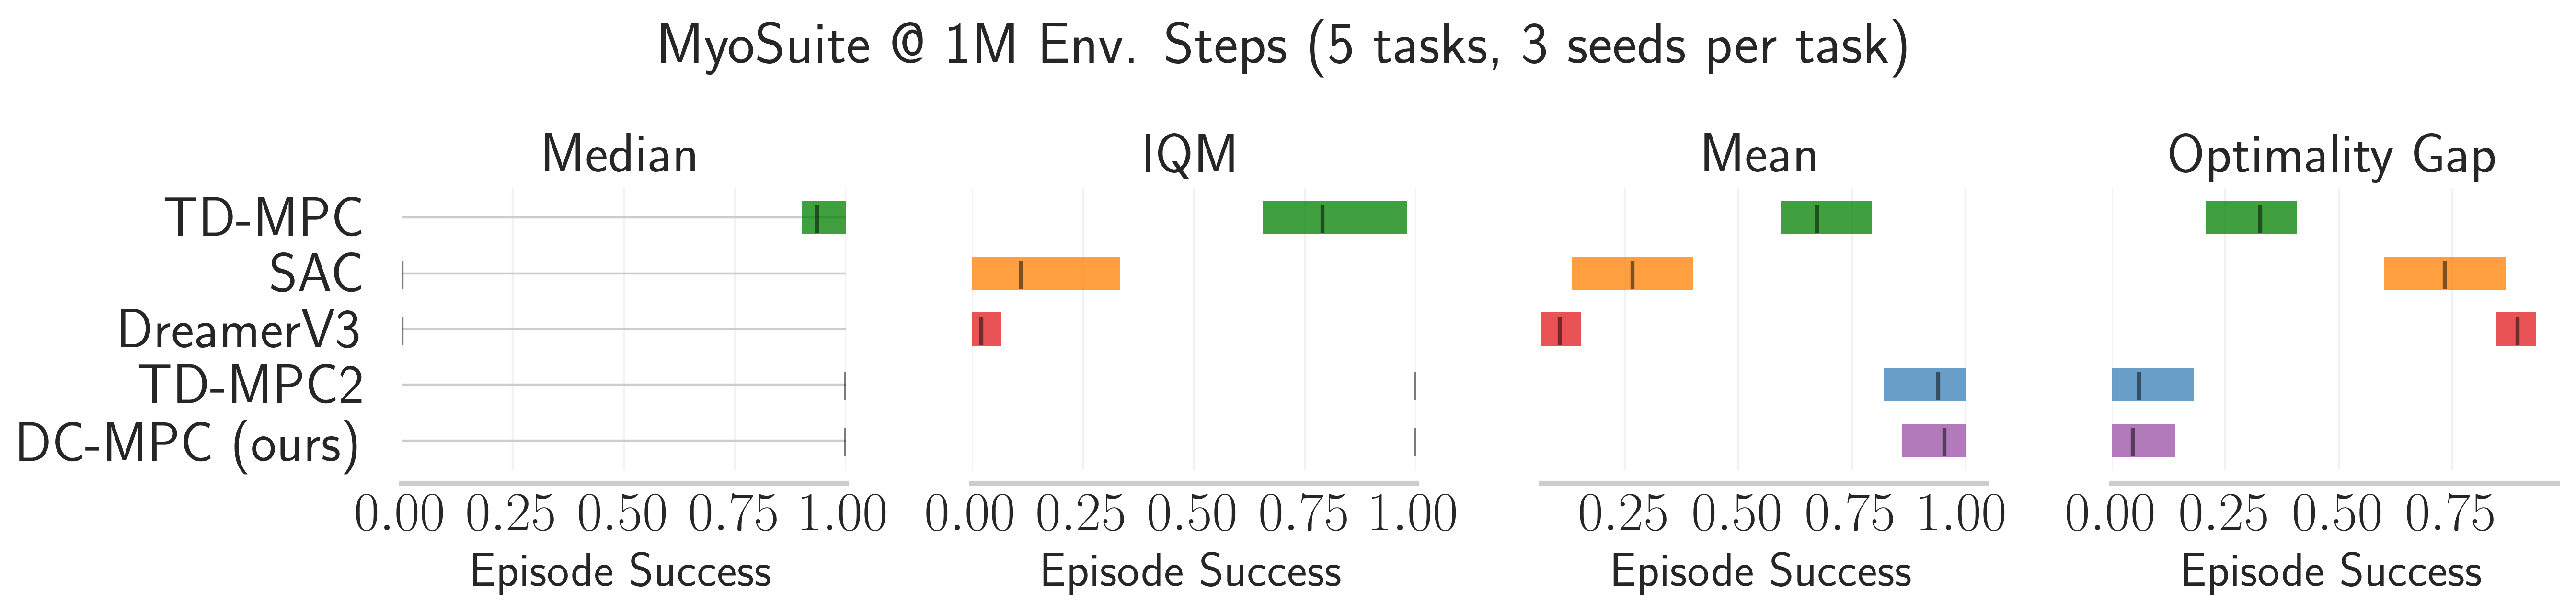

In [5]:
def plot_myo_agg_metrics(df, verbose: bool = False):
    plt.rcParams["font.size"] = 12
    plt.rcParams["legend.fontsize"] = 12

    ENV_STEP = 500000
    ENV_STEP = 1000000

    # Only keep selected agents
    df["agent"] = df["agent"].replace(utils.AGENTS)
    df = df[df["agent"].isin(utils.PALETTE.keys())]

    ##### Only keep envs where DCWM (Sample) has 1M steps #####
    df["env"] = df["env"].str.replace("_", "-")
    df = df[df["env"].isin(main_envs)]

    ##### Only use 3 seeds #####
    SEEDS = [0, 1, 2, 3, 4, 5]
    SEEDS = [1, 2, 3]
    good_df = []
    for agent in utils.PALETTE.keys():
        for env in df.env.unique():
            num_seeds = 0
            for seed in SEEDS:
                df_ = df[
                    (df["agent"] == agent)
                    & (df["env"] == env)
                    & (df["seed"] == seed)
                    & (df["env_step"] >= ENV_STEP)
                ]
                df_closest = df_.iloc[(df_["env_step"] - ENV_STEP).abs().argsort()[:1]]
                if num_seeds < 3:
                    good_df.append(df_closest)
                if not df_.empty:
                    num_seeds += 1

    df = pd.concat(good_df)

    def check_envs():
        for agent in df.agent.unique():
            for env in df.env.unique():
                agent_envs = df[df["agent"] == agent].env.unique()
                if env not in agent_envs:
                    print(f"{env} is NOT in {agent}")
                num_seeds = df[
                    (df["agent"] == agent) & (df["env"] == env)
                ].seed.unique()
                env_steps = df[
                    (df["agent"] == agent) & (df["env"] == env)
                ].env_step.unique()
                print(f"{num_seeds} for {agent} in {env}, env_step={env_steps}")

    if verbose:
        check_envs()

    # Use episode success as the normailized score as it's between 0-1
    df["norm_score"] = df["episode_success"]

    scores_dict = {}
    # Loop over each unique agent to create a separate array for each
    # for agent in df["agent"].unique():
    for agent in utils.AGENTS.values():
        # Filter the DataFrame for the current agent
        agent_df = df[df["agent"] == agent]

        # Pivot the filtered DataFrame to create a multi-indexed table with "seed" as rows, "env" and "env_step" as columns
        pivoted_df = agent_df.pivot_table(
            values="norm_score", index="seed", columns=["env"]
        )

        # Convert the pivoted DataFrame to a numpy array
        array = pivoted_df.to_numpy(copy=True)

        # Reshape the array based on the unique counts of "seed", "env", and "env_step"
        array = array.reshape(
            len(agent_df["seed"].unique()), len(agent_df["env"].unique())
        )

        # Add the array to the dictionary with the agent as the key
        scores_dict[agent] = array

    # Load ALE scores as a dictionary mapping algorithms to their human normalized
    # score matrices, each of which is of size `(num_runs x num_games)`.
    # atari_200m_normalized_score_dict = ...
    aggregate_func = lambda x: np.array(
        [
            metrics.aggregate_median(x),
            metrics.aggregate_iqm(x),
            metrics.aggregate_mean(x),
            metrics.aggregate_optimality_gap(x),
        ]
    )
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        scores_dict, aggregate_func, reps=50000
    )

    num_tasks = len(df.env.unique())
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names=[
            "Median",
            "IQM",
            "Mean",
            "Optimality Gap",
        ],
        xlabel="",
        colors=utils.PALETTE,
        row_height=0.65,
    )

    for ax in axes:
        ax.set_xlabel("Episode Success", fontsize=18)

    steps = {500000: "500k", 1000000: "1M", 900000: "1M"}
    fig.suptitle(
        f"MyoSuite @ {steps[ENV_STEP]} Env. Steps ({num_tasks} tasks, {len(df.seed.unique())} seeds per task)",
        fontsize=22,
    )
    plt.tight_layout()
    plt.savefig(f"./figs/myo_agg_rliable_{steps[ENV_STEP]}.pdf")

plot_myo_agg_metrics(df, verbose=True)

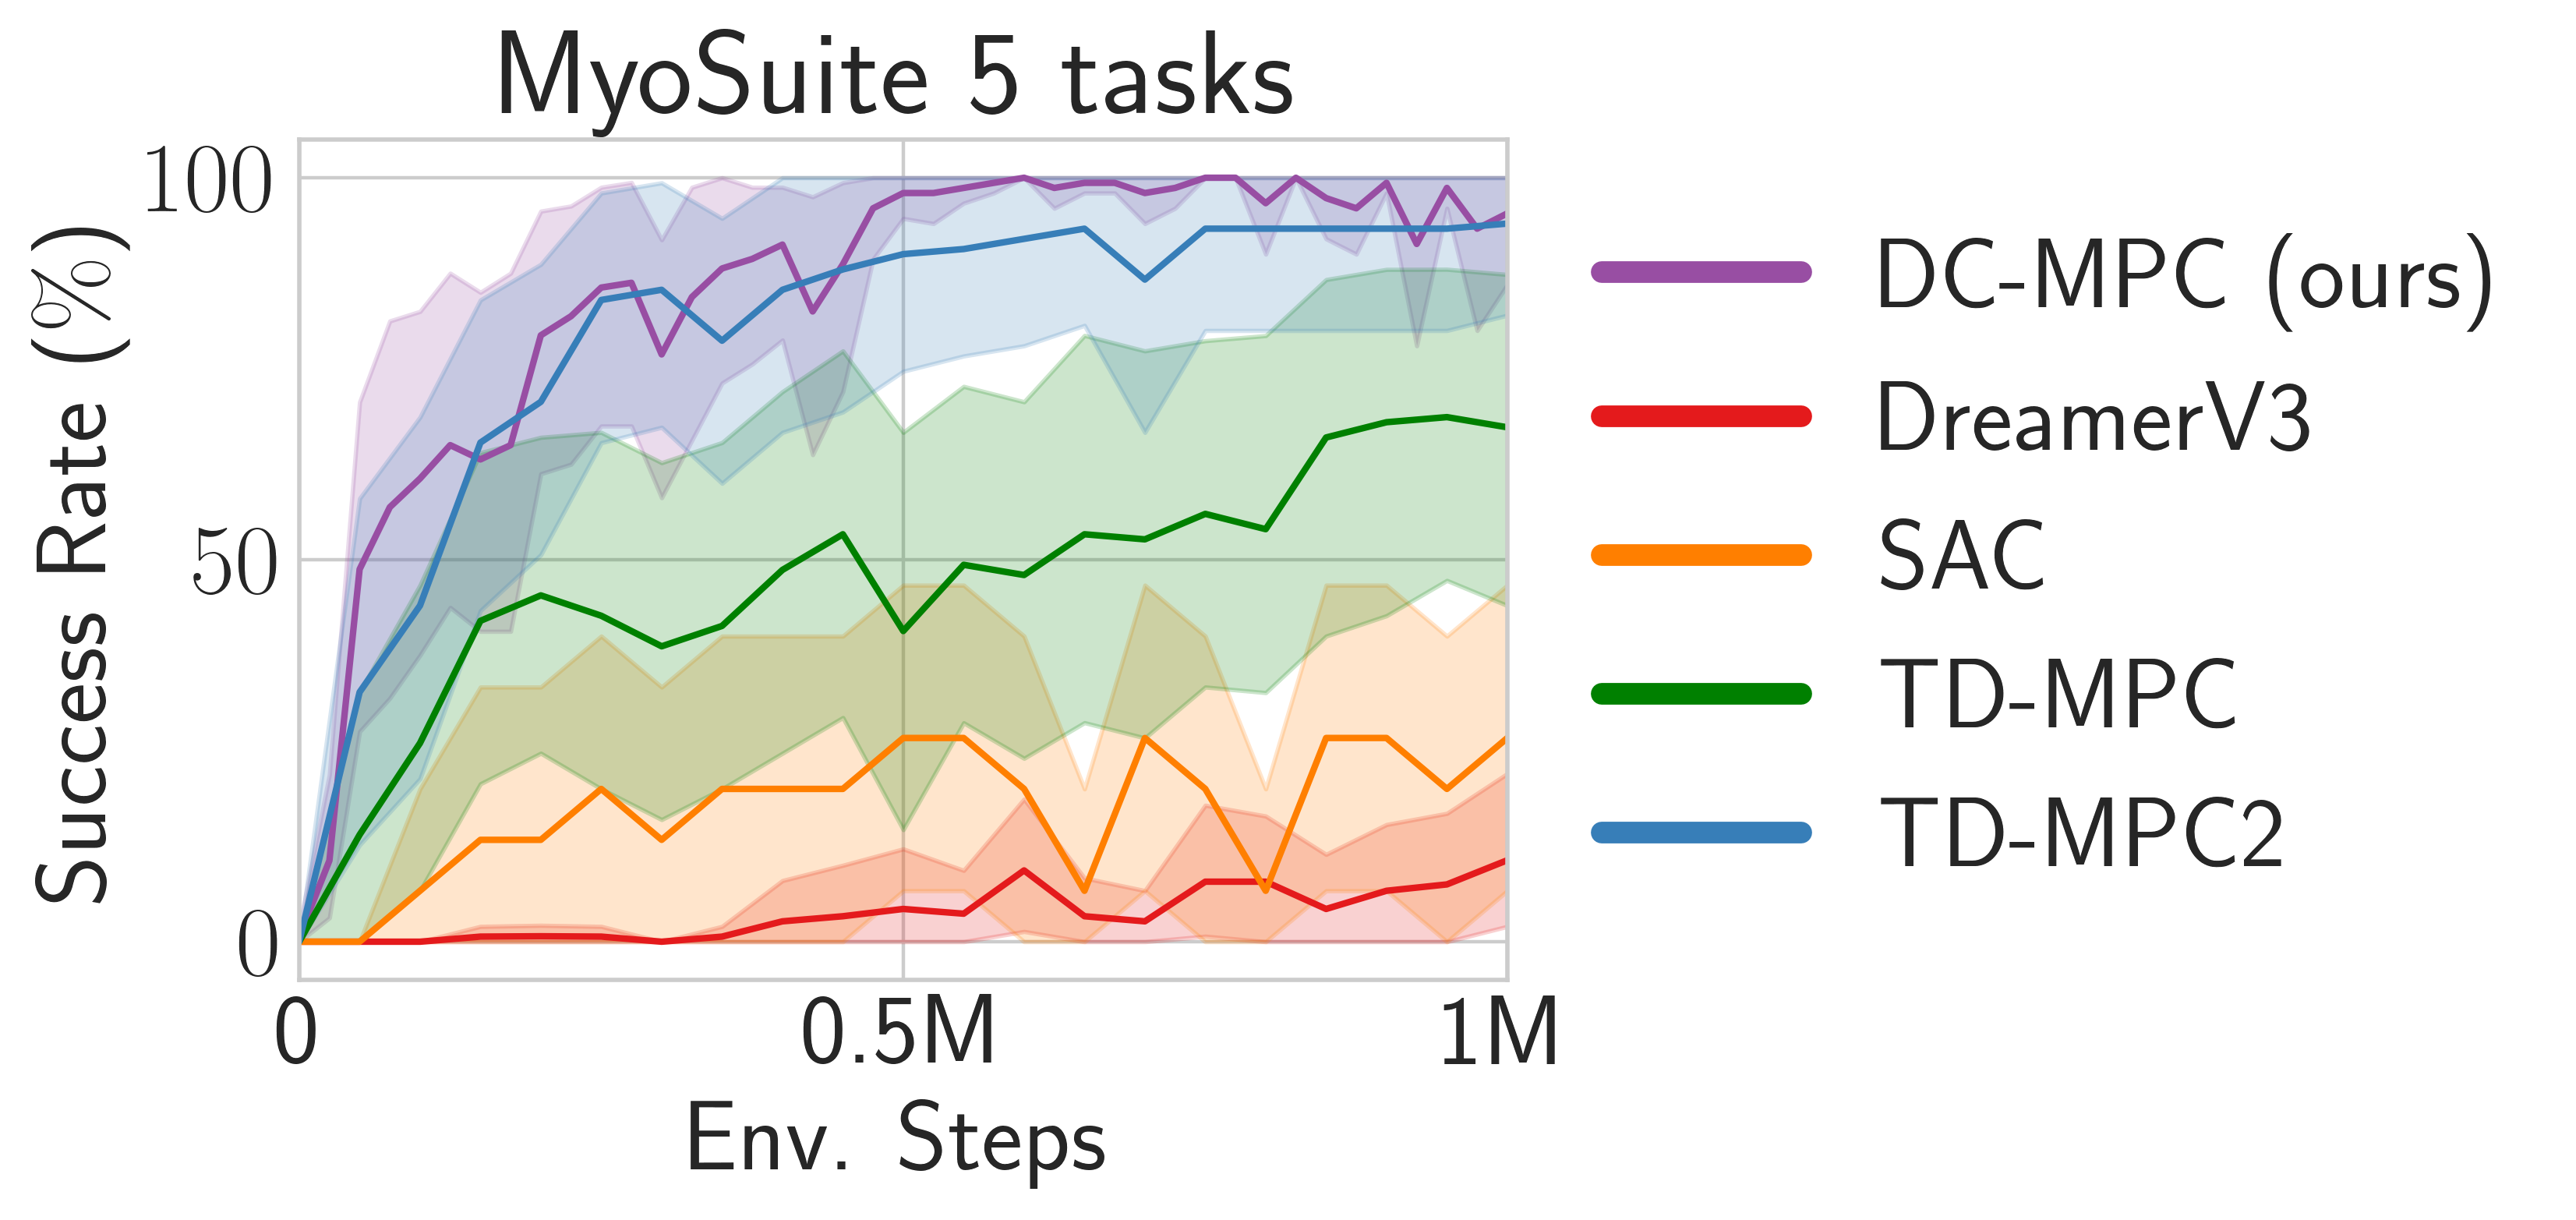

In [6]:
def plot_agg_training_curve(df, key="episode_success"):
    plt.rcParams["font.size"] = 23
    plt.rcParams["legend.fontsize"] = 23
    
    df = df[df["env"].isin(main_envs)]

    df.loc[:, "agent"] = df["agent"].replace(utils.AGENTS)

    fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

    df.loc[:, "episode_success"] = (df["episode_success"] * 100)

    g = sns.lineplot(
        x="env_step",
        y=key,
        data=df,
        errorbar=("ci", 95),
        hue="agent",
        hue_order=np.sort(df.agent.unique()),
        palette=utils.PALETTE,
        legend="auto",
        ax=ax,
    )

    num_tasks = len(df.env.unique())
    ax.set_title(f"MyoSuite {num_tasks} tasks")
    ax.set_xlabel("Env. Steps")
    g.set(xlim=(0, 1e6))
    ax.set_xticks((0, 0.5e6, 1e6))
    ax.set_xticklabels(("0", "0.5M", "1M"))

    ax.set_ylabel(utils.YLABELS[key])

    l = ax.legend(
        loc="right",
        bbox_to_anchor=(1.9, 0.5),
    )
    for line in l.get_lines():
        line.set_linewidth(5.0)
    plt.savefig(f"./figs/myosuite-agg-training-curve.pdf", bbox_inches="tight")

plot_agg_training_curve(df)